# Model to Understand Presidential Sentiment On Major Political Topics
This notebook is used for Preprossing, EDA, and sentiment analysis of text on 991 Presidental speeches that span all US Presidents from George Washington to Donald Trump mid-term 2019.

### Setup
Install modules and import libraries to run this notebook >

In [5]:
# install textblob, wordcloud if needed by un-hashing and running:
#!pip install -U textblob
#!pip install wordcloud

In [6]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import pickle
import sys

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords

from textblob import TextBlob

import seaborn as sns; sns.set(font_scale=1.2)

import matplotlib.pyplot as plt

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celinaplaza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Exploratory Data Analysis (EDA)
Frist, pull in csv file received from [Kaggle](https://www.kaggle.com/littleotter/united-states-presidential-speeches) that includes presidential speeches from every US President starting with Washingon on 1789-04-30 to Trump on 2019-09-25.  Each row includes:
1. Date of speech
2. President
3. Party of President
4. Speech Title
5. Summary of Speech
6. Transcript
7. URL of source of transcript

In [8]:
# pull in full csv file of presidential speeches

potus_speech = pd.read_csv('csv/presidential_speeches.csv')

In [9]:
# see how many speeches are within this file

len(potus_speech)

992

In [10]:
# verify list of all columns expected 
potus_speech.columns

Index(['Date', 'President', 'Party', 'Speech Title', 'Summary', 'Transcript',
       'URL'],
      dtype='object')

-
#### Basic data cleaning
Examine the dataframe, reduce to only the values that will be needed, address null values, etc.

In [11]:
# drop URL columnn, as it will not be needed

potus_speech.drop(columns='URL', inplace=True)

In [12]:
# Here we see 687 summaries are missing so definitely will not be used
#    in analysis and will remove column entirely

potus_speech['Summary'].isna().value_counts() 

False    687
True     305
Name: Summary, dtype: int64

In [13]:
potus_speech.drop(columns='Summary', inplace=True)

In [14]:
# discovered one speech that is missing, so will remove from data

potus_speech.dropna(subset=['Transcript'], inplace=True)

# verify null speech deleted (expect 991)

len(potus_speech)

991

-<br/>
#### Narrow Examination to Text Data
For Natural Language Processing (NLP) work, create a file for just text of the presidental speeches as `transcripts` >

In [15]:
# create data set of only speech text for NLP preparation

transcripts = potus_speech['Transcript']

# verify single column and includes all transcripts

transcripts.shape

(991,)

In [16]:
# save transcripts as csv

transcripts.to_csv('csv/transcripts.csv')

Now let's start to clean up the text >

In [18]:
# prepare a function to do basic cleaning of transcripts

def clean_text_rd1(text):
    '''
    Make text lowercase, 
    remove punctuation, 
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

clean_basic = lambda x: clean_text_rd1(x)

In [19]:
# Apply basic cleaning to transcripts and verify looks okay

transcripts_clean_rd1 = pd.DataFrame(potus_speech.Transcript.apply(clean_basic))

In [20]:
# Function to apply more advanced cleaning to transcripts

def clean_text_rd2(text, tokenizer):
    '''
    Takes in a corpus and tokenizer,
    removes stopwords
    returns text without stopwords.
    '''
    stop_words = set(stopwords.words('english')) 
    cleaned_text = []
    for words in text:
        cleaned_words = []
        for word in tokenizer.tokenize(words):
            if word not in stop_words:
                cleaned_words.append(word)
        cleaned_text.append(' '.join(cleaned_words))
    return pd.DataFrame(cleaned_text, columns=['Transcript'])

In [21]:
transcripts_clean_rd2 = clean_text_rd2(transcripts_clean_rd1.Transcript, TreebankWordTokenizer())

In [22]:
transcripts_clean_rd2

Transcript
0    fellow citizens senate house representatives a...
1    whereas duty nations acknowledge providence al...
2    fellow citizens senate house representatives e...
3    fellow citizens senate house representatives m...
4    president united states mouth written speech s...
..                                                 ...
986  short time ago honor presiding swearing five n...
987  madam speaker mr vice president members congre...
988  thank much everybody begin id like say large t...
989  thank much mr president mr secretarygeneral di...
990  thank much thank well thank weve tremendous th...

[991 rows x 1 columns]

Now pickle the cleaned transcripts for use later >

In [23]:
# save cleaned transcripts as csv

with open('pickle/transcripts_clean_rd2.pickle', 'wb') as to_write:
    pickle.dump(transcripts_clean_rd2, to_write)

-<br/>
Now text is in a good enough place to transform into a document-matrix to start basic analysis.  We'll start with using a Count Vectorizer to get count for each term in the documents >

In [24]:
cv = CountVectorizer(stop_words='english')
transcript_cv = cv.fit_transform(transcripts_clean_rd2.Transcript)
transcript_cv_dtm = pd.DataFrame(transcript_cv.toarray(), columns=cv.get_feature_names())
transcript_cv_dtm

# and pickle it for later use in topic creation
with open('pickle/cv_stop.pickle', 'wb') as to_write:
    pickle.dump(cv, to_write)

In [25]:
# also pickle the document-term matrix of the transcripts

with open('pickle/transcript_cv_dtm.pickle', 'wb') as to_write:
    pickle.dump(transcript_cv_dtm, to_write)

In [26]:
# Transpose the dataframe for analysis

transcript_dtm_cv_trans = transcript_cv_dtm.T

In [27]:
# Find the top 20 words said in each speech/transcript
#   Look at potential themes and/or stop words to consider for future work

top_20_dict = {}
for transcript in transcript_dtm_cv_trans.columns:
    top = transcript_dtm_cv_trans[transcript].sort_values(ascending=False).head(20)
    top_20_dict[transcript]= list(zip(top.index, top.values))


In [28]:
# Print the top 15 words said in each speech
# note this list will be very long (991) when printed!  

for speech, top_words in top_20_dict.items():
    print(speech)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

0
government, public, present, people, citizens, country, ought, duty, united, measures, hand, far, great, happiness
---
1
government, great, people, national, unto, nations, providence, almighty, grateful, protection, degree, day, establish, god
---
2
measures, public, good, states, regard, render, end, government, country, people, united, general, important, essential
---
3
public, citizens, great, means, national, commerce, present, country, valuable, objects, states, representatives, requisite, powers
---
4
states, united, lands, indians, shall, future, present, speech, friendship, bad, government, nations, desire, make
---
5
states, united, public, proper, important, provision, government, measures, objects, law, present, time, debt, necessary
---
6
states, representatives, numbers, respective, number, act, according, thirty, constitution, thousand, shall, applied, house, return
---
7
provision, citizens, information, law, proper, subject, states, present, service, attention, unit

#### Wordclouds
Let's make some word clouds to get a better visual sense of some trends we might see for Presidents.  We'll only look at a sample and then will use specific word clouds as needed to examine specific speeches.

In [29]:
from wordcloud import WordCloud

addtl_stop_words = ["said","every","may","going","theyre","get","that","thats","make","ever","shall"]

wc = WordCloud(stopwords=addtl_stop_words,background_color="white", colormap="Dark2",
               max_font_size=100, random_state=42)

George Washington


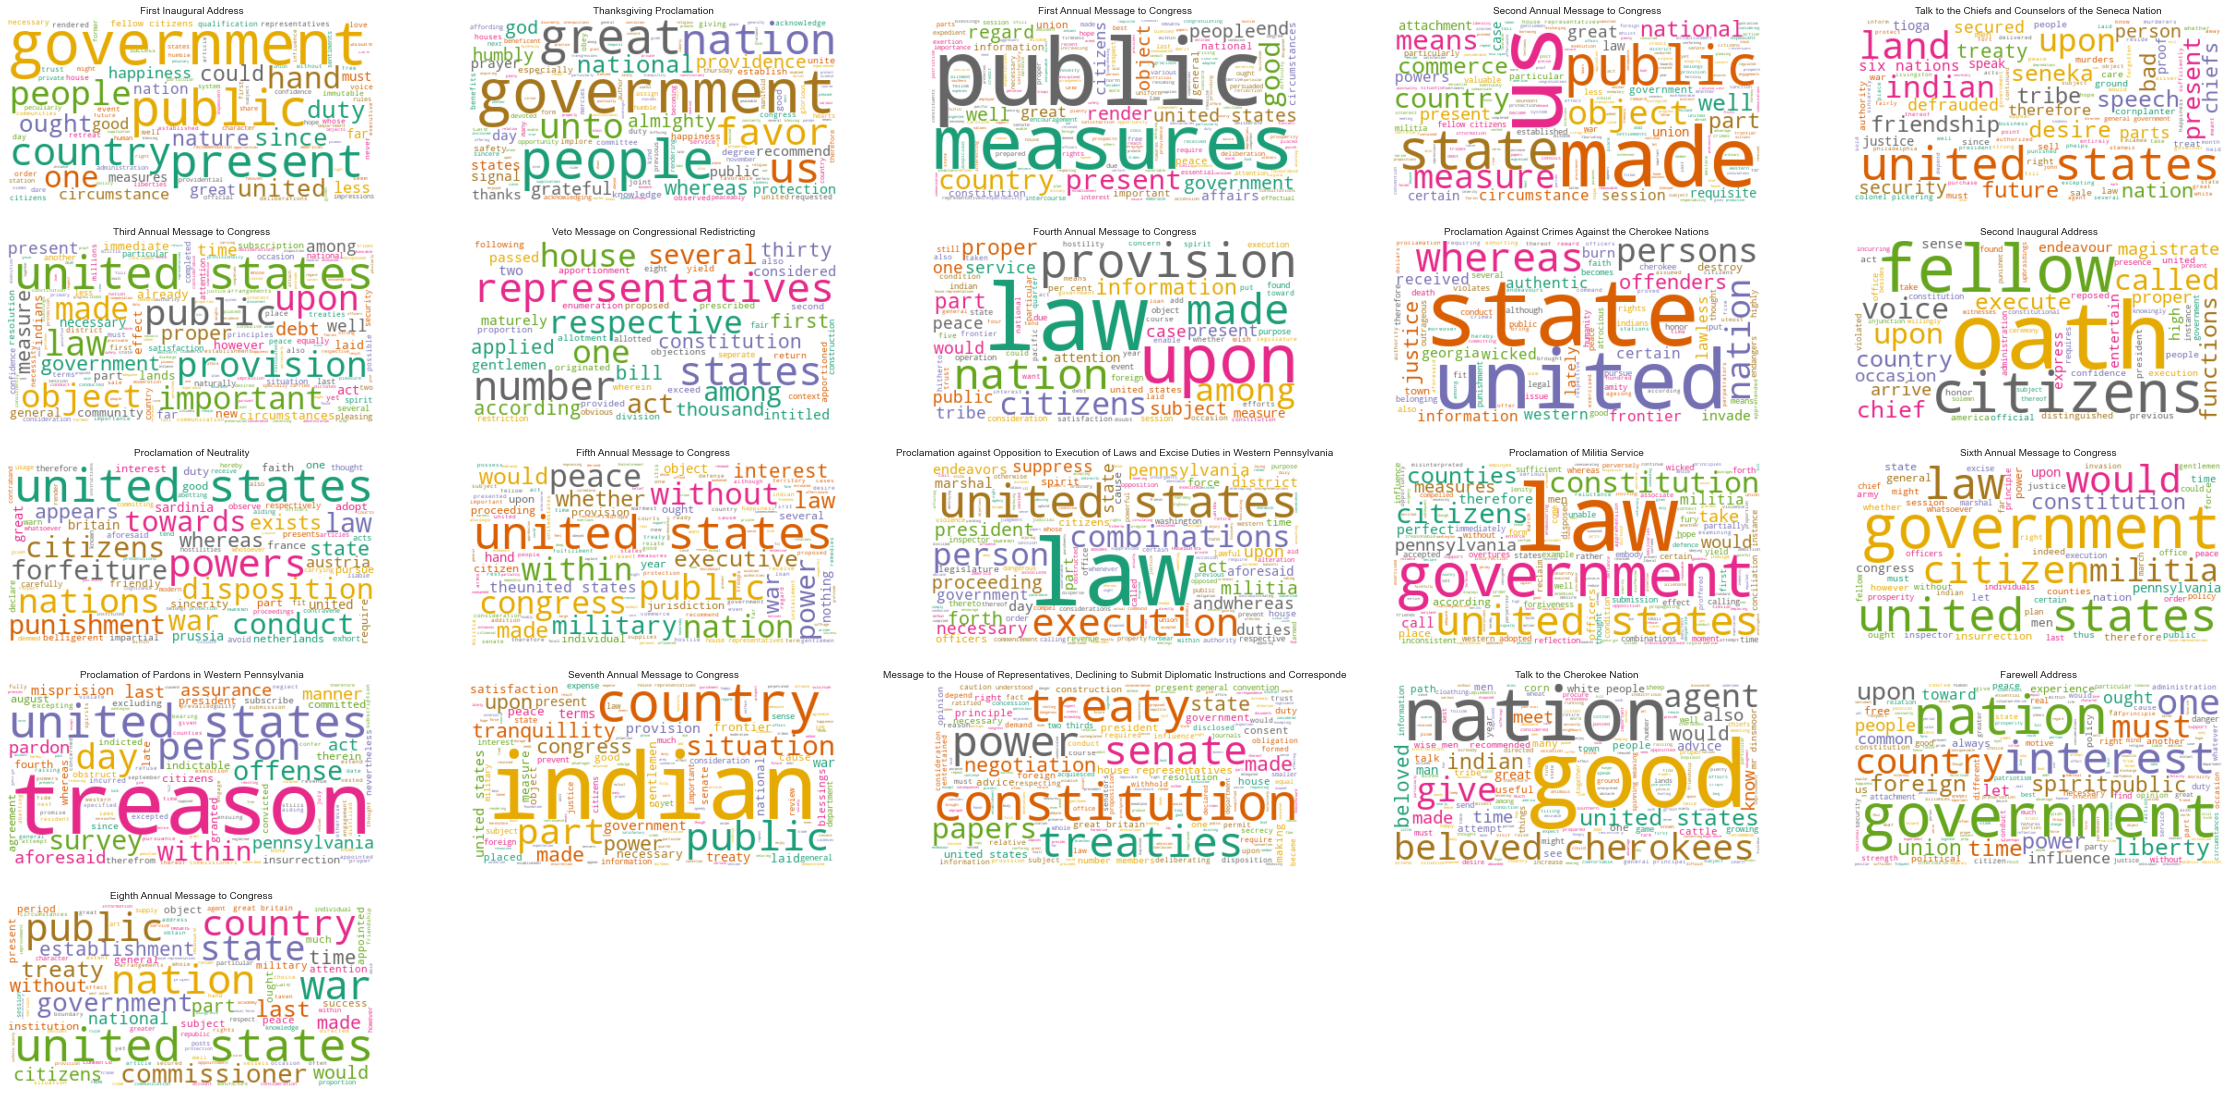

In [30]:
# Create wordclouds for all of George Washington's speeches

plt.rcParams['figure.figsize'] = [40, 40]

speech_dates = list(potus_speech['Speech Title'][:21])

# Create plots just for single president
for index, date in enumerate(transcript_dtm_cv_trans.columns[:21]):
    wc.generate(transcripts_clean_rd2.Transcript[date])
    
    plt.subplot(10, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(speech_dates[index],size=10)

print('George Washington')
plt.show()

Barack Obama Second Term


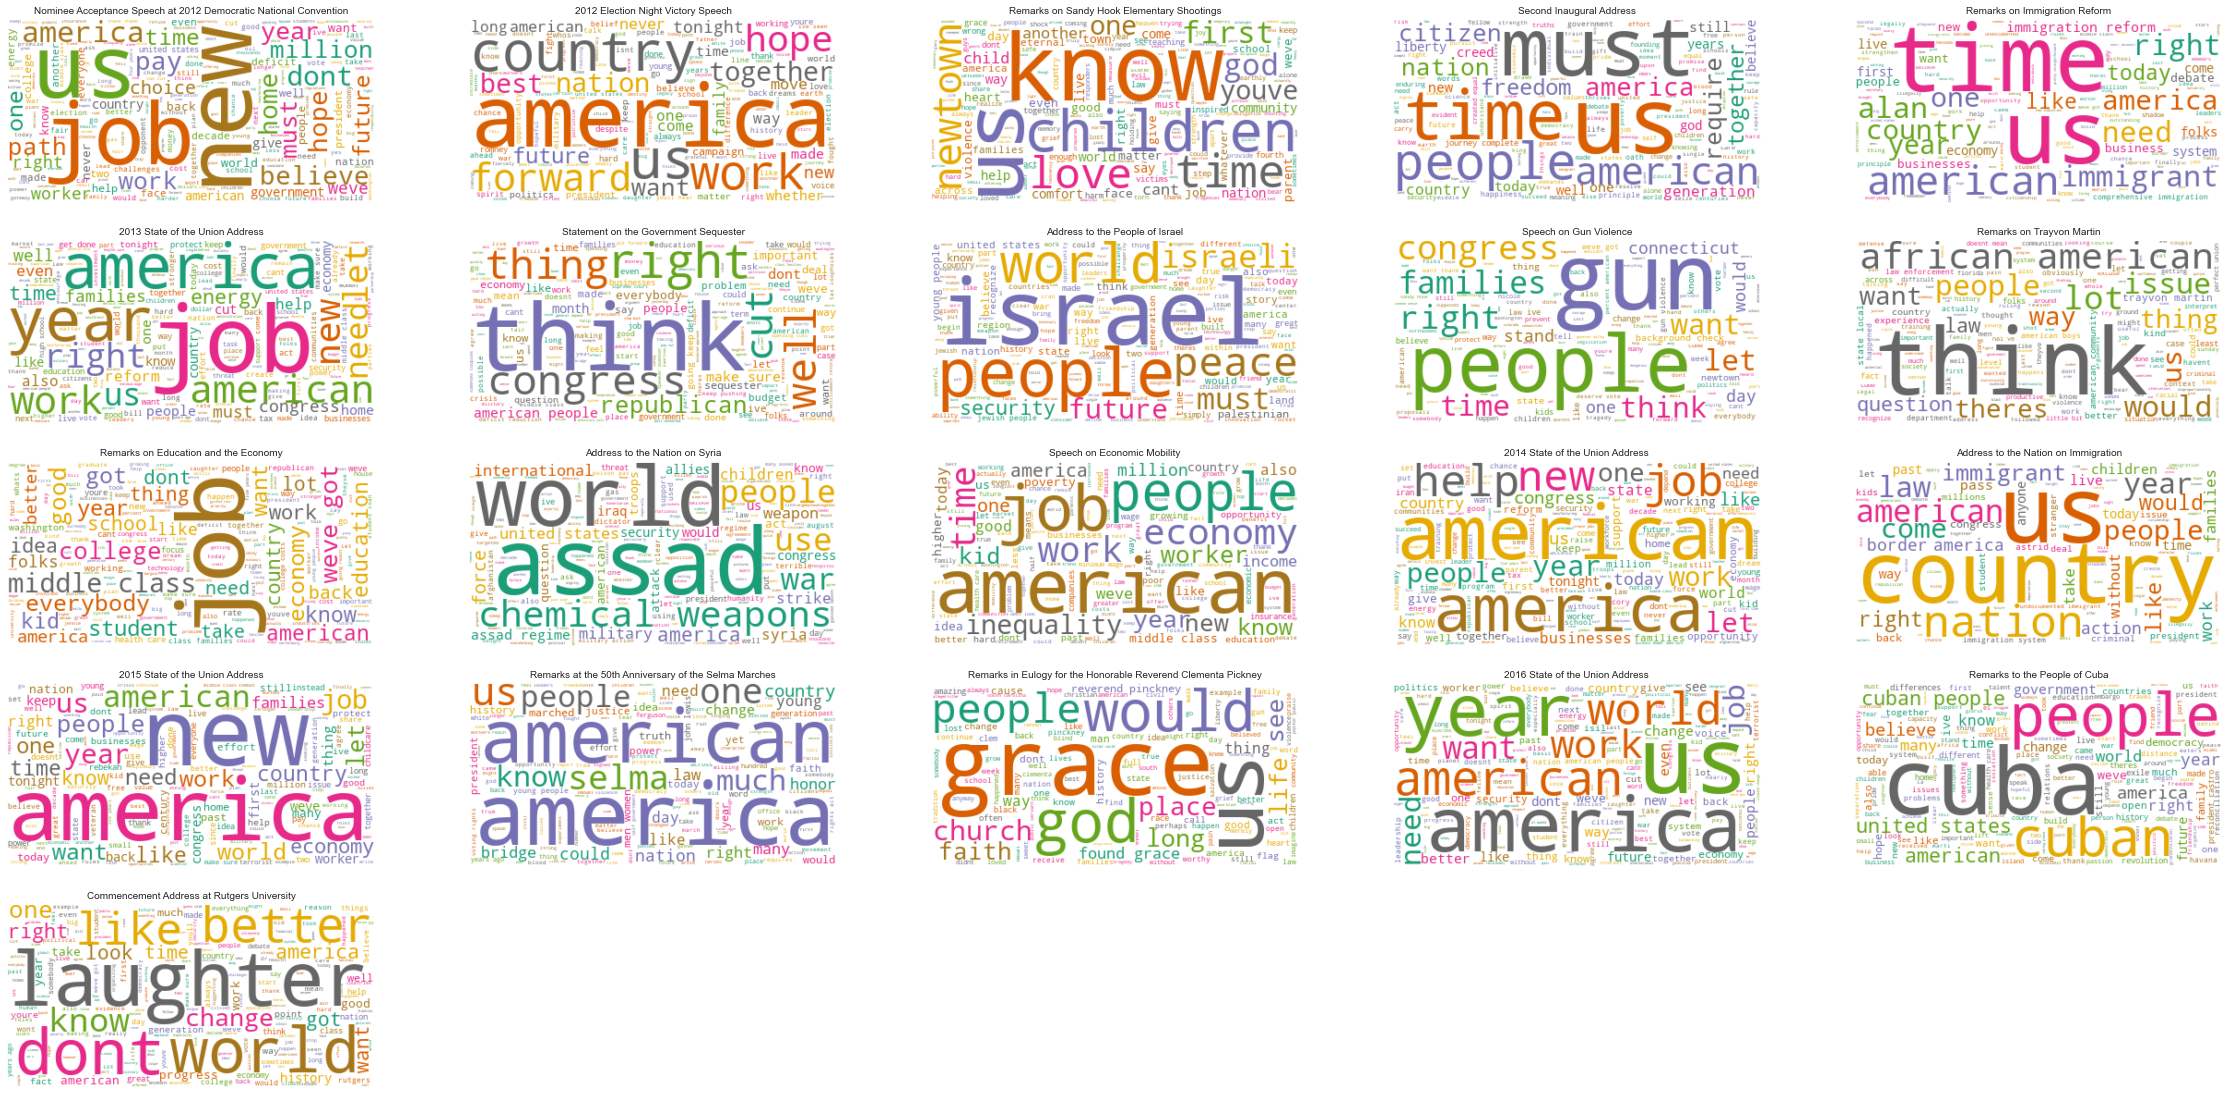

In [31]:
# Create wordclouds for all of Barack Obama's speeches

plt.rcParams['figure.figsize'] = [40, 40]

speech_dates = list(potus_speech['Speech Title'][951:972])

# Create plots just for single president
for index, date in enumerate(transcript_dtm_cv_trans.columns[951:972]):
    wc.generate(transcripts_clean_rd2.Transcript[date])
    
    plt.subplot(10, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(speech_dates[index],size=10)

print('Barack Obama Second Term')
plt.show()

Donald Trump


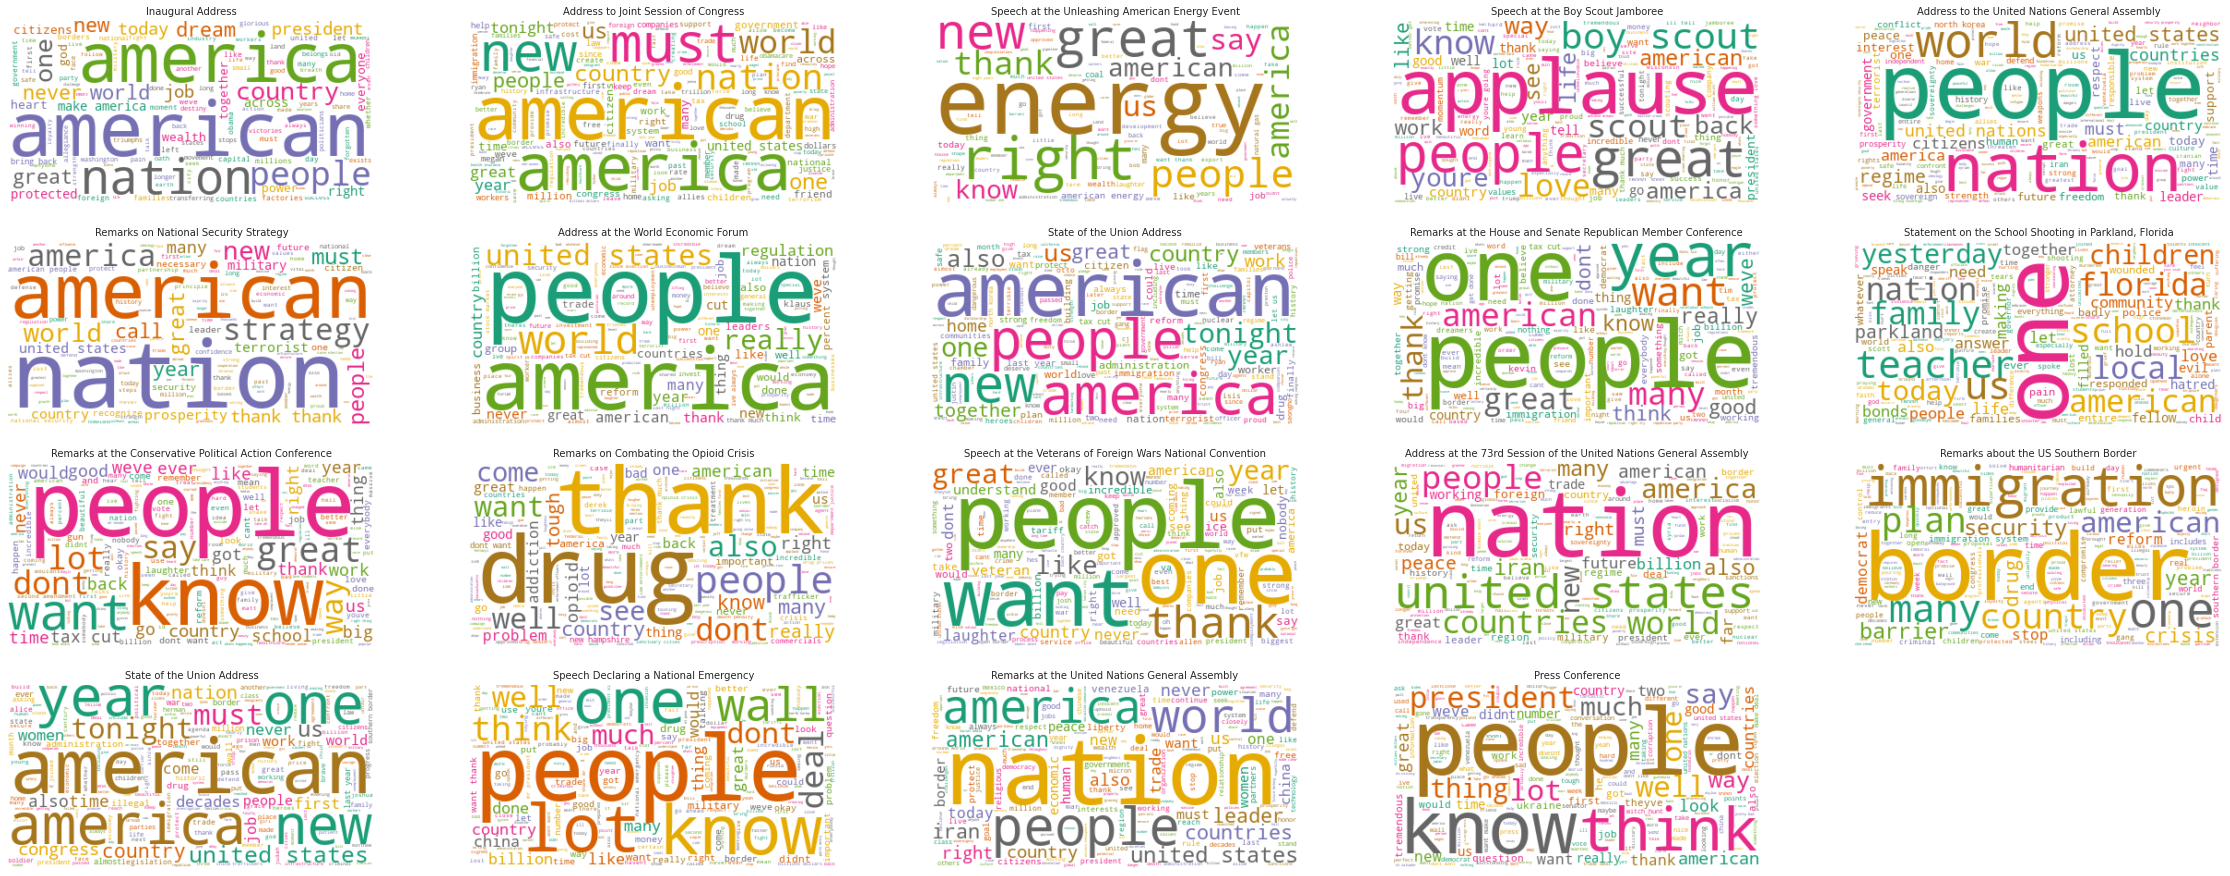

In [135]:
# Create wordclouds for all of Donald Trump's speeches

plt.rcParams['figure.figsize'] = [40, 40]

speech_dates = list(potus_speech['Speech Title'][-19:])

# Create plots just for single president
for index, date in enumerate(transcript_dtm_cv_trans.columns[-19:]):
    wc.generate(transcripts_clean_rd2.Transcript[date])
    
    plt.subplot(10, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(speech_dates[index],size=10)

print('Donald Trump')
plt.show()

Takeaways of wordclouds:
Keeping in mind that these words are not stemmed so this isn't accounting for variation of words (e.g. war vs. wars), but still can observe that:
- **Washingon**: speeches seemed to use more variety of words (not a lot of singular stand-outs) and 'law', 'government', and other terms related to government structure are often used.
- **Obama**: has focus on 'us', 'america', and 'jobs'
- **Trump**: in particular really dominates usage of 'people' and 'america'/'american', and emphasis on 'new'

## Sentiment Analysis
Get an understanding of sentiment and polarity for each speech.

In [32]:
# Create lambda functions to find the polarity and subjectivity of each speech

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

potus_speech['polarity'] = potus_speech['Transcript'].apply(pol)
potus_speech['subjectivity'] = potus_speech['Transcript'].apply(sub)
potus_speech.head()

Date          President         Party  \
0  1789-04-30  George Washington  Unaffiliated   
1  1789-10-03  George Washington  Unaffiliated   
2  1790-01-08  George Washington  Unaffiliated   
3  1790-12-08  George Washington  Unaffiliated   
4  1790-12-29  George Washington  Unaffiliated   

                                        Speech Title  \
0                            First Inaugural Address   
1                          Thanksgiving Proclamation   
2                   First Annual Message to Congress   
3                  Second Annual Message to Congress   
4  Talk to the Chiefs and Counselors of the Senec...   

                                          Transcript  polarity  subjectivity  
0  Fellow Citizens of the Senate and the House of...  0.206467      0.428960  
1  Whereas it is the duty of all Nations to ackno...  0.263889      0.470370  
2  Fellow Citizens of the Senate and House of Rep...  0.203224      0.443704  
3  Fellow citizens of the Senate and House of Rep...  0.173927      0.464649  
4  I the President of the United States, by my ow...  0.097168      0.485468

In [33]:
#Create copy of dataframe with sentiments
potus_speech_sentiment = potus_speech.copy()

#Then save it as csv to be pulled into Tableau for visualization
potus_speech_sentiment.to_csv('csv/potus_speech_sentiment.csv')

In [34]:
potus_speech_sentiment.head()

Date          President         Party  \
0  1789-04-30  George Washington  Unaffiliated   
1  1789-10-03  George Washington  Unaffiliated   
2  1790-01-08  George Washington  Unaffiliated   
3  1790-12-08  George Washington  Unaffiliated   
4  1790-12-29  George Washington  Unaffiliated   

                                        Speech Title  \
0                            First Inaugural Address   
1                          Thanksgiving Proclamation   
2                   First Annual Message to Congress   
3                  Second Annual Message to Congress   
4  Talk to the Chiefs and Counselors of the Senec...   

                                          Transcript  polarity  subjectivity  
0  Fellow Citizens of the Senate and the House of...  0.206467      0.428960  
1  Whereas it is the duty of all Nations to ackno...  0.263889      0.470370  
2  Fellow Citizens of the Senate and House of Rep...  0.203224      0.443704  
3  Fellow citizens of the Senate and House of Rep...  0.173927      0.464649  
4  I the President of the United States, by my ow...  0.097168      0.485468

In [35]:
#Let's see who's speech has the highest polarity

potus_speech_sentiment[potus_speech_sentiment['polarity'] == potus_speech_sentiment['polarity'].max()]

Date        President       Party      Speech Title  \
218  1861-02-11  Abraham Lincoln  Republican  Farewell Address   

                                            Transcript  polarity  subjectivity  
218  My friends No one, not in my situation, can ap...  0.358333      0.472222

#### Takeaways of polarity:
Interesting to note here that in reading the 'most negative' speech's text, it's not necessarily 'negative' -- it's Lincoln's expression of sadness about leaving.  Will make note of this when building the sentiment analysis results and graphs.

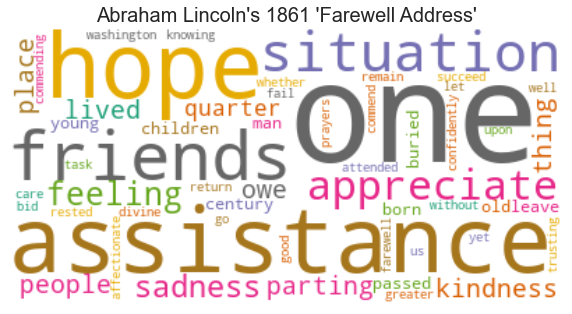

In [36]:
# Create word cloud for speech identified as greatest polarity

plt.rcParams['figure.figsize'] = [10, 10]

# Create plots just for single president
wc.generate(transcripts_clean_rd2.Transcript[217])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Abraham Lincoln's 1861 'Farewell Address'",size=20)

plt.show()

Takeaways of Polarity analysis:
- Interesting to note here that in reading the 'most negative' speech's text, but Lincoln's farewell speech to be seen as 'negative' would not be right.  He's **sad** to be leaving, but as seen in the wordcloud, there is also a message of hope, friends, appreciation, and other positive sentiments.  A learning to not take sentiment ratings at their face value.  Will make note of this when building the sentiment analysis results and graphs.

In [37]:
#Highest subjectivity speech

potus_speech_sentiment[potus_speech_sentiment['subjectivity'] == potus_speech_sentiment['subjectivity'].max()]

Date          President       Party          Speech Title  \
462  1920-07-22  Warren G. Harding  Republican  The American Soldier   

                                            Transcript  polarity  subjectivity  
462  My countrymen, though not in any partisan sens...  0.260367      0.609494

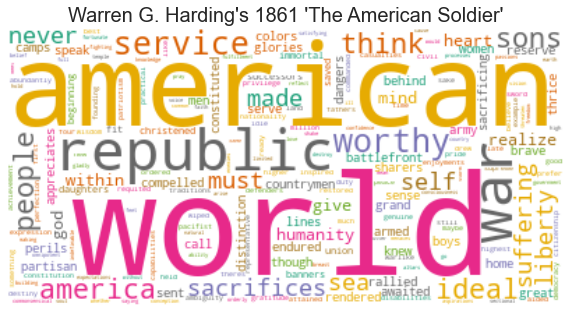

In [38]:
# Create word cloud for speech identified as greatest subjectivity

plt.rcParams['figure.figsize'] = [10, 10]

# Create plots just for single president
wc.generate(transcripts_clean_rd2.Transcript[461])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Warren G. Harding's 1861 'The American Soldier'",size=20)

plt.show()

In [39]:
# Lowest polarity speech

potus_speech_sentiment[potus_speech_sentiment['polarity'] == potus_speech_sentiment['polarity'].min()]

Date      President       Party  \
170  1848-08-01  James K. Polk  Democratic   

                           Speech Title  \
170  Message Regarding Size of the Army   

                                            Transcript  polarity  subjectivity  
170  I communicate herewith a report from the Secre... -0.087603      0.356095

In [40]:
# Lowest subjectivity speech

potus_speech_sentiment[potus_speech_sentiment['subjectivity'] == potus_speech_sentiment['subjectivity'].min()]

Date      President       Party  \
168  1848-07-04  James K. Polk  Democratic   

                                 Speech Title  \
168  Announcement of Peace Treaty with Mexico   

                                            Transcript  polarity  subjectivity  
168  Whereas a treaty of peace, friendship, limits,... -0.004545      0.189394

In [41]:
potus_speech_sentiment.columns

Index(['Date', 'President', 'Party', 'Speech Title', 'Transcript', 'polarity',
       'subjectivity'],
      dtype='object')

In [42]:
# Now let's create sentiment averages for the Presidents

potus_sentiment_only = potus_speech_sentiment.drop(columns=['Date','Speech Title','Transcript'])

potus_grouped_sentiment = potus_sentiment_only.groupby(
    ['President', 'Party'])[
    'polarity','subjectivity'].mean().reset_index()

#Then save it as csv to be pulled into Tableau for visualization
potus_grouped_sentiment.to_csv('csv/potus_grouped_sentiment.csv')

# Sort by polarity and subjectivity to see who is strongest and lowest in these areas

potus_grouped_sentiment.sort_values(by=['subjectivity'], ascending=False)

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


President                  Party  polarity  subjectivity
8            Donald Trump             Republican  0.143820      0.502093
19      James A. Garfield             Republican  0.162603      0.498542
42         Woodrow Wilson             Democratic  0.125781      0.492843
39       William Harrison                   Whig  0.151383      0.487550
17        Harry S. Truman             Democratic  0.161106      0.483067
26        John F. Kennedy             Democratic  0.135339      0.476264
9    Dwight D. Eisenhower             Republican  0.143460      0.475798
32       Richard M. Nixon             Republican  0.146029      0.470804
4       Benjamin Harrison             Republican  0.132958      0.469086
35     Theodore Roosevelt             Republican  0.107379      0.467252
13         George W. Bush             Republican  0.135834      0.467076
38      Warren G. Harding             Republican  0.153206      0.465412
25             John Adams             Federalist  0.141827      0.463485
0         Abraham Lincoln             Republican  0.138170      0.461106
20         James Buchanan             Democratic  0.092465      0.459842
12      George H. W. Bush             Republican  0.113961      0.459781
24           Jimmy Carter             Democratic  0.127829      0.458170
3            Barack Obama             Democratic  0.115452      0.458046
41           William Taft             Republican  0.116167      0.456754
33          Ronald Reagan             Republican  0.110019      0.455731
5            Bill Clinton             Democratic  0.133133      0.455600
28             John Tyler           Unaffiliated  0.106833      0.454832
43         Zachary Taylor                   Whig  0.127335      0.454058
29      Lyndon B. Johnson             Democratic  0.147459      0.453529
36       Thomas Jefferson  Democratic-Republican  0.146698      0.452082
6         Calvin Coolidge             Republican  0.153957      0.451028
10  Franklin D. Roosevelt             Democratic  0.123242      0.448752
30       Martin Van Buren             Democratic  0.101113      0.446663
7       Chester A. Arthur             Republican  0.108542      0.446547
15            Gerald Ford             Republican  0.144457      0.443891
23           James Monroe  Democratic-Republican  0.157945      0.440779
16       Grover Cleveland             Democratic  0.094239      0.440563
1          Andrew Jackson             Democratic  0.109808      0.437550
14      George Washington           Unaffiliated  0.123695      0.436063
37       Ulysses S. Grant             Republican  0.099640      0.424391
31       Millard Fillmore                   Whig  0.107138      0.422368
18         Herbert Hoover             Republican  0.117023      0.422085
40       William McKinley             Republican  0.112541      0.419777
2          Andrew Johnson             Democratic  0.070623      0.415183
34    Rutherford B. Hayes             Republican  0.094714      0.409385
21          James K. Polk             Democratic  0.093961      0.408018
11        Franklin Pierce             Democratic  0.083041      0.407990
22          James Madison  Democratic-Republican  0.128825      0.405318
27      John Quincy Adams  Democratic-Republican  0.096080      0.377881

#### Takeaways from senitments by President:
- Polarity:
    - James Garfield has most polarity (positive) on average
    - Andrew Johnson has least polarity (negative) on average
    - Political parties are mixed along the way -- no clear pattern of parties being more or less polarizing
- Subjectivity:
    - Donald Trump has most subjectivity (opinion-based) on average
    - John Quincy Ad has least subjectivity (opinion-based) on average
    - Political parties are mixed along the way -- no clear pattern of parties being more or less polarizing

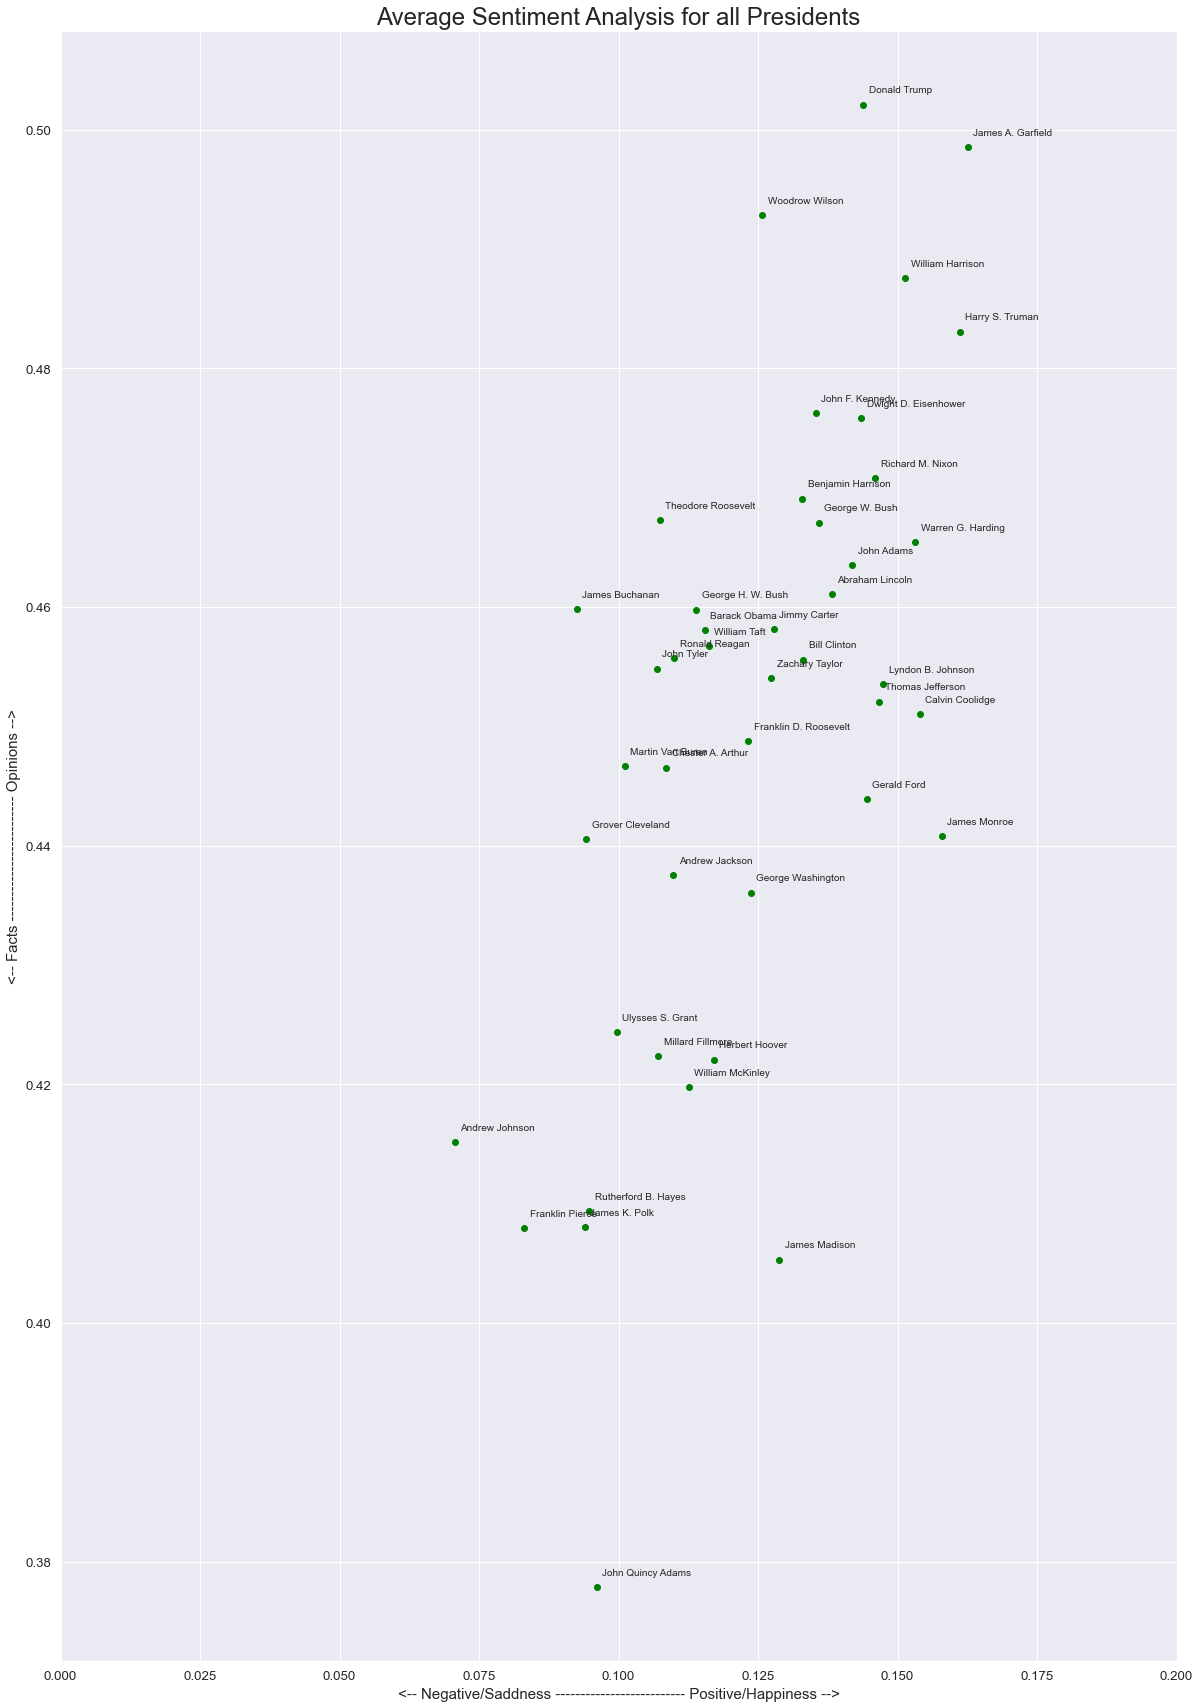

In [43]:
# Plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 30]

for index, president in enumerate(potus_grouped_sentiment.index):
    x = potus_grouped_sentiment.polarity.loc[president]
    y = potus_grouped_sentiment.subjectivity.loc[president]
    plt.scatter(x, y, color='green')
    plt.text(x+.001, y+.001, potus_grouped_sentiment['President'][index], fontsize=10)
    plt.xlim(0, .20) 
    
plt.title('Average Sentiment Analysis for all Presidents', fontsize=24)
plt.xlabel('<-- Negative/Saddness -------------------------- Positive/Happiness -->', fontsize=15)
plt.ylabel('<-- Facts ------------------------- Opinions -->', fontsize=15)

plt.show()

#### Takeaways from senitments by President plot:
- Subjectivity seems to waiver more than Polarity between Presidents.  Many are similiar, clustered in the center, but there are a few outliers on either end of subjectivity.
- This graph is hard to reach with Presidents overlapping -- will recreate graph in Tableau with improved layout for readability.